# Импорт библиотек

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

def print_metriks(y_true, y_pred):
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.03f}')
    print(f'MSE: {mean_squared_error(y_true, y_pred):.03f}')
    print(f'R2: {r2_score(y_true, y_pred):.03f}')
    print()

# Загрузка датасета

In [5]:
df = pd.read_csv("../data/energydata_complete.csv")
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


# Анализ распределений

In [7]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

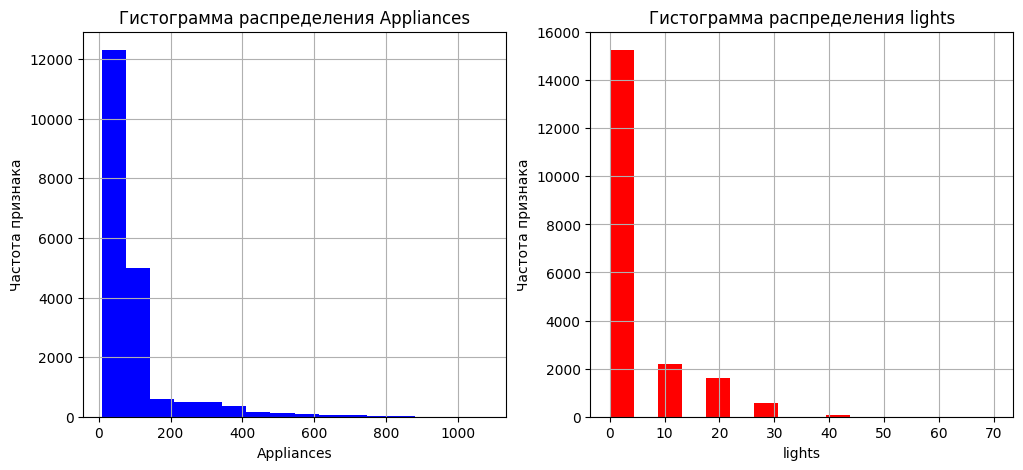

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df['Appliances'].hist(bins=16, ax=ax[0], color="blue")
df['lights'].hist(bins=16, ax=ax[1], color="red")
ax[0].set_xlabel("Appliances")
ax[0].set_ylabel("Частота признака")
ax[0].set_title("Гистограмма распределения Appliances")
ax[1].set_xlabel("lights")
ax[1].set_ylabel("Частота признака")
ax[1].set_title("Гистограмма распределения lights")
print()

Оба распределения похожи на логнормальное распределение

In [ ]:
sns.pairplot(df)

Пояснение: картинка с парным распределением настолько большая, что файл не загружается на платформу. Вставил сжатый вариант ниже

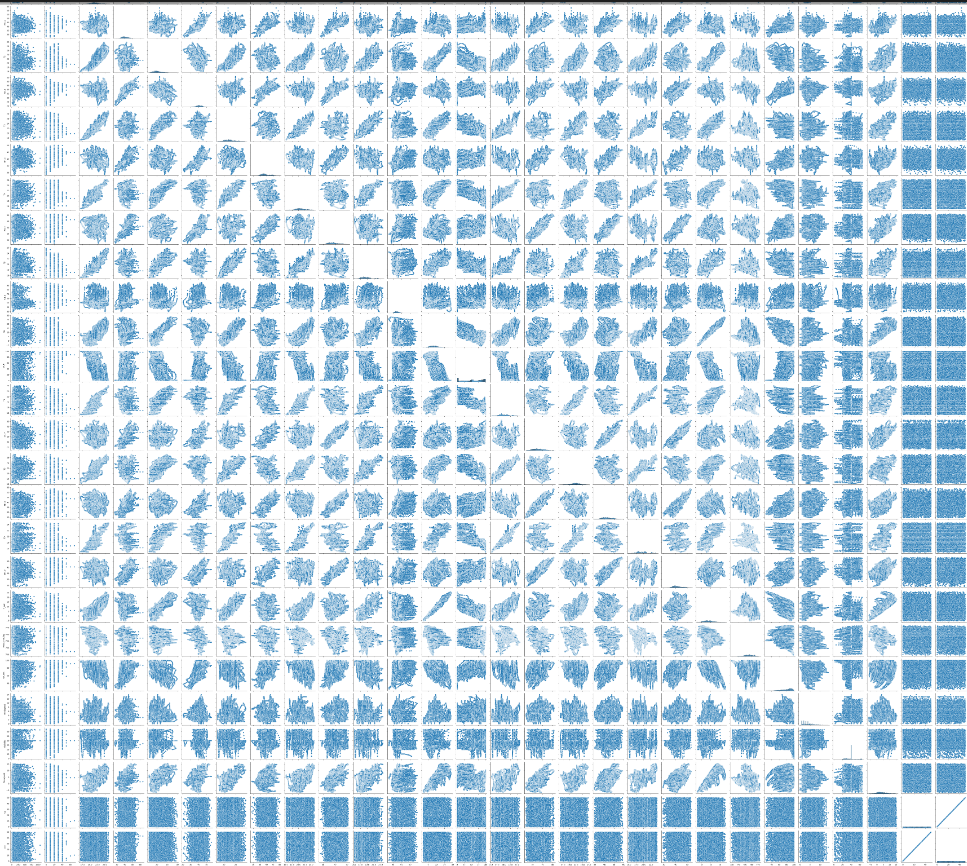

Признаков тут много, поэтому не очень хорошо видно. Однако, можно сказать, что последние два признака 'rv1', 'rv2' содержат какой-то шум, можно от них избавиться. Также избавимся от признака даты, так как сейчас мы не занимаемся анализом временных рядов. Судя по распределениям признаки 'Windspeed', 'Visibility', 'Tdewpoint' линейно не связаны с нашими таргетами, можно тоже их убрать.

In [8]:
df = df.loc[:, ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out']]

Lights и Аppliances плохо линейно зависит от других признаков, вряд ли линейные модели могут хорошо решить регрессионную задачу на этих данных. При этом самих признако много, можно долго с ними работать, провести feature engineering, однака это совсем другая задача. Посмотрим какие метрики получим имея такие данные.

In [10]:
X = df.loc[:, ['T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out']]
y = df.loc[:, ['Appliances', 'lights']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [11]:
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [16]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [19]:
print("Метрики на обучающей выборке")
print_metriks(y_train, y_pred_train)
print("Метрики на тестовой выборке")
print_metriks(y_test, y_pred_test)

Метрики на обучающей выборке
MAE: 29.357
MSE: 4619.592
R2: 0.179

Метрики на тестовой выборке
MAE: 29.014
MSE: 4157.247
R2: 0.189



Ожидаемо, метрики получились плохие. Модель обладает низкой обобщающей способностью, модель может объяснить не более 20% дисперсии ответов. Попробуем взять другую модель.

In [36]:
pls_model = PLSRegression(n_components=21)
pls_model.fit(X_train, y_train)
y_pred_train = pls_model.predict(X_train)
y_pred_test = pls_model.predict(X_test)

print("Метрики на обучающей выборке")
print_metriks(y_train, y_pred_train)
print("Метрики на тестовой выборке")
print_metriks(y_test, y_pred_test)

Метрики на обучающей выборке
MAE: 29.357
MSE: 4619.592
R2: 0.179

Метрики на тестовой выборке
MAE: 29.014
MSE: 4157.247
R2: 0.189



Получилось то же самое, не очень хорошо

In [46]:
knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(X_train, y_train)

y_pred_train = knn_model.predict(X_train)
y_pred_test = knn_model.predict(X_test)

print("Метрики на обучающей выборке")
print_metriks(y_train, y_pred_train)
print("Метрики на тестовой выборке")
print_metriks(y_test, y_pred_test)

Метрики на обучающей выборке
MAE: 8.448
MSE: 756.532
R2: 0.872

Метрики на тестовой выборке
MAE: 15.566
MSE: 2259.447
R2: 0.593



А вот это гораздо лучше. Модель может объяснить 59% дисперсии ответов.